In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nuztf.neutrino_scanner import NeutrinoScanner
from astropy import units as u
from nuwinter.avro import load_avro
from nuwinter.plot import ann_fields, generate_single_page
from nuwinter.utils import deduplicate_df
from nuwinter.paths import get_pdf_path
from pathlib import Path
import pandas as pd
import json
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from tqdm import tqdm
from nuztf.skymap_scanner import SkymapScanner
from winterapi import WinterAPI
from astropy.time import Time
from mocpy import MOC
from astropy.coordinates import (
    ICRS,
    Angle,
    BaseCoordinateFrame,
    Galactic,
    Latitude,
    Longitude,
    SkyCoord,
)
from astropy.io import fits
import healpy as hp
import logging

/opt/anaconda3/envs/nuwinter/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
# Program details
program = "2023A001" # WINTER EMGW

name = "S250206dm"

prob_threshold = 0.95
n_days = 14

image_type="diff"

In [4]:
winter = WinterAPI()
program_list = winter.get_programs()
print(f"Available programs: {program_list}")
assert program in program_list, f"program {program} not found! Add this program first."

INFO:winterapi.messenger:API ping success is True
INFO:winterapi.messenger:Server requires minimum winterapi version: 1.5.0
INFO:winterapi.messenger:Local winterapi version: 1.5.0


Available programs: ['2023A001']


In [5]:
nu = NeutrinoScanner(name) if "IC" in name else SkymapScanner(
    event=name,
    prob_threshold=prob_threshold,
    n_days=n_days,
    output_nside=1024
)

INFO:nuztf.skymap:Obtaining skymap from GraceDB
INFO:nuztf.skymap:Found voevent S250206dm-7-Update.xml
INFO:nuztf.skymap:Latest skymap URL: https://gracedb.ligo.org/api/superevents/S250206dm/files/Bilby.offline1.multiorder.fits,0
INFO:nuztf.skymap:Saving to: /Users/rdstein/Data/nuztf/skymaps/S250206dm_rev7_Bilby.offline1.multiorder.fits,0
INFO:nuztf.skymap:Reading file: /Users/rdstein/Data/nuztf/skymaps/S250206dm_rev7_Bilby.offline1.multiorder.fits,0
INFO:nuztf.skymap:Rasterising skymap to convert to nested format
INFO:nuztf.skymap:Summed probability is 100.0%
INFO:nuztf.skymap:Regridding to nside 1024
INFO:nuztf.skymap:Event time: 2025-02-06T21:25:30.452
INFO:nuztf.skymap:Reading map
INFO:nuztf.skymap:Threshold found! 
 To reach 95.00% of probability, pixels with probability greater than 3.9e-07 are included.
INFO:nuztf.skymap_scanner:hottest_pixel: 38.17319848293299 53.23540420437919
INFO:nuztf.skymap_scanner:Checking which pixels are within the contour:
100%|████████████████████████

In [6]:
nu.t_min.isot.split("T")[0].replace("-", "")

'20250206'

In [7]:
t_end = min([nu.default_t_max, Time.now()])

res, stacks = winter.query_images_by_program(
    program, image_type="stack",
    start_date=nu.t_min.isot.split("T")[0].replace("-", ""),
    end_date=t_end.isot.split("T")[0].replace("-", "")
)

Querying images for 2023A001 between 20250206 and 20250220 of type 'stack'


In [8]:
res.json()["msg"]

'Request passed validation! Found 465 images.'

In [9]:
stacks

,progname,nightdate,targname,ra,dec,fid,utctime,fieldid,image_type,savepath,lastmodified,pipeversion
0,2023A001,2025-02-09,2025ban,152.84400,-18.875515,2,2025-02-09T16:58:45.274000+00:00,999999999,stack,/data/loki/data/winter/20250208/final/WINTERca...,2025-02-09T11:13:09.883864+00:00,0.19.0
1,2023A001,2025-02-18,GRB250217C,130.78719,33.327890,2,2025-02-18T12:54:04.434000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
2,2023A001,2025-02-18,GRB250217C,130.80641,32.990776,2,2025-02-18T12:54:04.434000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
3,2023A001,2025-02-18,GRB250217C,131.51578,33.681920,2,2025-02-18T12:56:11.930000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
4,2023A001,2025-02-18,GRB250217C,131.51663,32.995903,2,2025-02-18T12:58:19.039000+00:00,999999999,stack,/data/loki/data/winter/20250217/final/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
460,2023A001,2025-02-08,S250206dm_neutrino1_1,148.86841,-17.841703,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0
461,2023A001,2025-02-08,S250206dm_neutrino1_1,148.87534,-18.179558,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0
462,2023A001,2025-02-08,S250206dm_neutrino1_1,149.50185,-18.179625,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0
463,2023A001,2025-02-08,S250206dm_neutrino1_1,149.50322,-17.494430,2,2025-02-08T14:26:07.963000+00:00,999999999,stack,/data/loki/data/winter/20250207/final/WINTERca...,2025-02-08T11:08:31.067326+00:00,0.19.0


In [10]:
print(stacks["utctime"][0], stacks["savepath"][0])

2025-02-09T16:58:45.274000+00:00 /data/loki/data/winter/20250208/final/WINTERcamera_20250209-085845-274_mef_4_0_0_stack.fits


/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_17813/3161930814.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(stacks["utctime"][0], stacks["savepath"][0])


In [11]:
res, diffs = winter.query_images_by_program(
    program, image_type="diff",
    start_date=nu.t_min.isot.split("T")[0].replace("-", ""),
    end_date=t_end.isot.split("T")[0].replace("-", "")
)

Querying images for 2023A001 between 20250206 and 20250220 of type 'diff'


In [12]:
diffs

,progname,nightdate,targname,ra,dec,fid,utctime,fieldid,image_type,savepath,lastmodified,pipeversion
0,2023A001,2025-02-18,GRB250217C,130.787190,33.327890,2,2025-02-18T12:54:04.434000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
1,2023A001,2025-02-18,GRB250217C,130.806410,32.990776,2,2025-02-18T12:54:04.434000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
2,2023A001,2025-02-18,GRB250217C,131.515780,33.681920,2,2025-02-18T12:56:11.930000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
3,2023A001,2025-02-18,GRB250217C,131.516630,32.995903,2,2025-02-18T12:58:19.039000+00:00,999999999,diff,/data/loki/data/winter/20250217/diffs/WINTERca...,2025-02-18T11:28:20.693295+00:00,0.19.0
4,2023A001,2025-02-08,S250206dm,36.099724,55.324870,2,2025-02-08T15:54:14.173000+00:00,3635,diff,/data/loki/data/winter/20250207/diffs/WINTERca...,2025-02-08T11:08:34.697189+00:00,0.19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
369,2023A001,2025-02-17,S250206dm,32.940460,51.025360,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.372927+00:00,0.19.0
370,2023A001,2025-02-17,S250206dm,32.952366,50.688004,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.282405+00:00,0.19.0
371,2023A001,2025-02-17,S250206dm,33.894040,50.690525,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.372927+00:00,0.19.0
372,2023A001,2025-02-17,S250206dm,33.899640,51.375286,2,2025-02-17T12:49:37.205000+00:00,4489,diff,/data/loki/data/winter/20250216/diffs/WINTERca...,2025-02-17T11:30:21.372927+00:00,0.19.0


In [13]:
stack_roots = [Path(x).name.split(".")[0] for x in stacks["savepath"]]
diff_roots = [Path(x).name.split(".")[0] for x in diffs["savepath"]]
has_diff = [x in diff_roots for x in stack_roots]

In [14]:
# mocs = MOC.from_boxes(
#     lon=images["ra"].to_numpy() * u.deg,
#     lat=images["dec"].to_numpy()  * u.deg,
#     a=0.5 * u.deg,
#     b=0.4 * u.deg,
#     angle=0 * u.deg,
#     max_depth=hp.nside2order(nu.nside),  # Match winter nside/order to skymap nside/order
# )

mocs = MOC.from_boxes(
    lon=stacks["ra"].to_numpy() * u.deg,
    lat=stacks["dec"].to_numpy()  * u.deg,
    a=0.25 * u.deg,
    b=0.2 * u.deg,
    angle=0 * u.deg,
    max_depth=hp.nside2order(nu.nside),  # Match winter nside/order to skymap nside/order
)

In [15]:
# images["ra"]

In [16]:
print(nu.nside)

1024


In [17]:
pixels = [x.flatten() for x in mocs]
all_times = [Time(x.split("+")[0], format="isot") - 8*u.hour for x in stacks["utctime"]]  # 8 hours offset, database times are palomar
all_times

[<Time object: scale='utc' format='isot' value=2025-02-09T08:58:45.274>,
 <Time object: scale='utc' format='isot' value=2025-02-18T04:54:04.434>,
 <Time object: scale='utc' format='isot' value=2025-02-18T04:54:04.434>,
 <Time object: scale='utc' format='isot' value=2025-02-18T04:56:11.930>,
 <Time object: scale='utc' format='isot' value=2025-02-18T04:58:19.039>,
 <Time object: scale='utc' format='isot' value=2025-02-08T07:54:14.173>,
 <Time object: scale='utc' format='isot' value=2025-02-08T07:54:14.173>,
 <Time object: scale='utc' format='isot' value=2025-02-08T07:54:14.173>,
 <Time object: scale='utc' format='isot' value=2025-02-08T07:54:14.173>,
 <Time object: scale='utc' format='isot' value=2025-02-08T07:54:14.173>,
 <Time object: scale='utc' format='isot' value=2025-02-08T07:56:21.321>,
 <Time object: scale='utc' format='isot' value=2025-02-08T06:44:50.635>,
 <Time object: scale='utc' format='isot' value=2025-02-08T06:44:50.635>,
 <Time object: scale='utc' format='isot' value=2025

In [18]:
pix_obs_times = dict()
pix_has_diff = []

for i, obs_time in tqdm(enumerate(all_times), total=len(all_times)):
    
    pixels = hp.nest2ring(nu.nside, np.array(mocs[i].flatten(), dtype=int))

    for p in pixels:
        if p not in pix_obs_times.keys():
            pix_obs_times[p] = [obs_time]
        else:
            pix_obs_times[p] += [obs_time]

    if has_diff[i]:
        pix_has_diff += list(pixels)

pix_has_diff = list(set(pix_has_diff))

100%|██████████████████████████████████████| 465/465 [00:00<00:00, 57728.32it/s]


In [19]:
min_sep=0.01

npix = hp.nside2npix(nu.nside)

ras, decs = hp.pixelfunc.pix2ang(
    nu.nside, hp.nest2ring(nu.nside, nu.pixel_nos), lonlat=True
)

radecs = SkyCoord(ra=ras * u.deg, dec=decs * u.deg)

radecs

coverage_data = []

times = []

for i, p in enumerate(tqdm(hp.nest2ring(nu.nside, nu.pixel_nos))):
    entry = {
        "pixel_no": p,
        "prob": nu.map_probs[i],
        "gal_b": radecs[i].galactic.b.deg,
        "in_plane": abs(radecs[i].galactic.b.deg) < 10.0,
        "ra_deg": ras[i],
        "dec_deg": decs[i],
        "has_diff": p in pix_has_diff
    }

    if p in pix_obs_times.keys():
        obs = pix_obs_times[p]

        entry["n_det_class"] = 2 if ((max(obs) - min(obs)) > min_sep) else 1

        entry["latency_days"] = min(obs) - nu.t_min.jd

        # overlapping_fields += pix_map[p]

        times += list(obs)
    else:
        entry["n_det_class"] = 0
        entry["latency_days"] = np.nan

    coverage_data.append(entry)

coverage_df = pd.DataFrame(coverage_data)

# _observations = data.query("obsjd in @times").reset_index(drop=True)[
#     ["obsjd", "exposure_time", "filter_id"]
# ]
# bands = [self.fid_to_band(fid) for fid in _observations["filter_id"].values]
# _observations["band"] = bands
# _observations.drop(columns=["filter_id"], inplace=True)
# self.observations = _observations

# self.logger.info("All observations:")
# self.logger.info(f"\n{self.observations}")

try:
    first_obs = Time(min(times), format="jd")
    first_obs.utc.format = "isot"
    last_obs = Time(max(times), format="jd")
    last_obs.utc.format = "isot"

except ValueError:
    err = (
        f"No observations of this event were found at any time between "
        f"{nu.t_min} and {nu.t_min + first_det_window_days * u.day}. "
        f"Coverage overlap is 0%!"
    )
    raise ValueError(err)

# self.logger.info(f"Observations started at {self.first_obs.isot}")

# return (
#     coverage_df,
#     times,
#     overlapping_fields,
# )

/opt/anaconda3/envs/nuwinter/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
100%|█████████████████████████████████| 265408/265408 [03:42<00:00, 1195.20it/s]


In [20]:
first_obs

<Time object: scale='utc' format='isot' value=2025-02-08T04:05:52.692>

In [21]:
coverage_df

,pixel_no,prob,gal_b,in_plane,ra_deg,dec_deg,has_diff,n_det_class,latency_days
0,1899571,3.978061e-07,-17.752062,False,25.061538,44.251119,False,0,NaN
1,1895675,3.978061e-07,-17.699818,False,25.087269,44.300699,False,0,NaN
2,1895674,3.978061e-07,-17.712855,False,24.994867,44.300699,False,0,NaN
3,1891782,3.978061e-07,-17.660639,False,25.020555,44.350271,False,0,NaN
4,1891783,3.978061e-07,-17.647576,False,25.113052,44.350271,False,0,NaN
...,...,...,...,...,...,...,...,...,...
265403,7616159,4.908374e-07,-46.301833,False,328.974609,-12.139140,False,0,NaN
265404,7616160,4.908374e-07,-46.378558,False,329.062500,-12.139140,False,0,NaN
265405,7612064,4.908374e-07,-46.399715,False,329.106445,-12.100988,False,0,NaN
265406,7612063,4.908374e-07,-46.323011,False,329.018555,-12.100988,False,0,NaN


In total, 39.5 % of the contour was observed at least once.
Of this total, 0.2 % did not produce a subtraction image.
A further 38.9 % of the contour is at a galactic latitude <10 deg.
In total, 36.5 % of the contour was observed at least twice. 
In total, 0.3 % of the contour was observed at least twice, and excluding low galactic latitudes.
 These estimates account for chip gaps and processing success rate.
11659 pixels were covered, covering approximately 38 sq deg.
Of these, 3412 pixels did not produce subtractions, covering approximately 11 sq deg.
6393 pixels were covered at least twice (b>10), covering approximately 21 sq deg.
8126 pixels were covered at low galactic latitude, covering approximately 27 sq deg.


/opt/anaconda3/envs/nuwinter/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3831: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


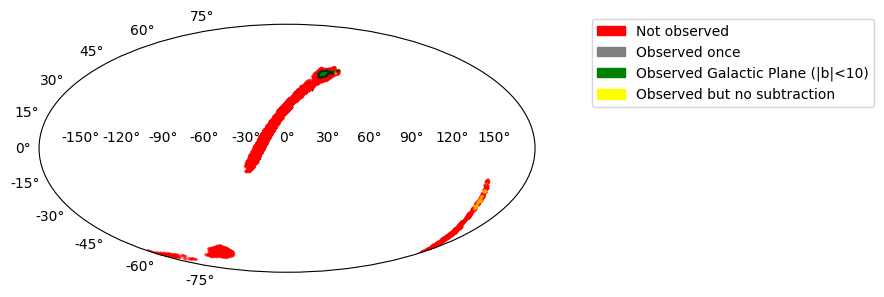

In [22]:
import matplotlib.patches as mpatches

fig = plt.figure()
plt.subplot(projection="aitoff")

overlap_mask = (coverage_df["n_det_class"] == 2) & ~coverage_df["in_plane"]
overlap_prob = coverage_df[overlap_mask]["prob"].sum() * 100.0

size = hp.max_pixrad(nu.nside) ** 2 * 50.0

veto_pixels = coverage_df.where(coverage_df["n_det_class"] == 0)

if len(veto_pixels) > 0:
    plt.scatter(
        np.radians(nu.wrap_around_180(veto_pixels["ra_deg"])),
        np.radians(veto_pixels["dec_deg"]),
        color="red",
        s=size,
    )

no_ref_pixels = coverage_df.where(
    ~coverage_df["has_diff"] & (coverage_df["n_det_class"] > 0)
)

if len(no_ref_pixels) > 0:
    plt.scatter(
        np.radians(nu.wrap_around_180(no_ref_pixels["ra_deg"])),
        np.radians(no_ref_pixels["dec_deg"]),
        color="yellow",
        s=size,
    )

plane_pixels = coverage_df.where(
    coverage_df["in_plane"] & (coverage_df["n_det_class"] > 0) & coverage_df["has_diff"]
)

if len(plane_pixels) > 0:
    plt.scatter(
        np.radians(nu.wrap_around_180(plane_pixels["ra_deg"])),
        np.radians(plane_pixels["dec_deg"]),
        color="green",
        s=size,
    )

single_pixels = coverage_df.where(
    ~coverage_df["in_plane"] & (coverage_df["n_det_class"] == 1) & coverage_df["has_diff"]
)

if len(single_pixels) > 0:
    plt.scatter(
        np.radians(nu.wrap_around_180(single_pixels["ra_deg"])),
        np.radians(single_pixels["dec_deg"]),
        c=single_pixels["prob"],
        vmin=0.0,
        vmax=max(nu.data[nu.key]),
        s=size,
        cmap="gray",
    )

double_pixels = coverage_df.where(
    ~coverage_df["in_plane"] & (coverage_df["n_det_class"] == 2) & coverage_df["has_diff"]
)

if len(double_pixels) > 0:
    plt.scatter(
        np.radians(nu.wrap_around_180(double_pixels["ra_deg"])),
        np.radians(double_pixels["dec_deg"]),
        c=double_pixels["prob"],
        vmin=0.0,
        vmax=max(nu.data[nu.key]),
        s=size,
    )

red_patch = mpatches.Patch(color="red", label="Not observed")
gray_patch = mpatches.Patch(color="gray", label="Observed once")
green_patch = mpatches.Patch(
    color="green", label="Observed Galactic Plane (|b|<10)"
)
yellow_patch = mpatches.Patch(
    color="yellow", label="Observed but no subtraction"
)
plt.legend(handles=[red_patch, gray_patch, green_patch, yellow_patch], bbox_to_anchor=(1.1, 1.05))

message = (
    f"In total, {100.0 * coverage_df.query('n_det_class > 0')['prob'].sum():.1f} % of the contour was observed at least once.\n"
    f"Of this total, {100.0 * coverage_df.query('n_det_class > 0 & ~has_diff')['prob'].sum():.1f} % did not produce a subtraction image.\n"
    f"A further {100.0 * coverage_df.query('in_plane & n_det_class > 0 & has_diff')['prob'].sum():.1f} % of the contour is at a galactic latitude <10 deg.\n"
    f"In total, {100.0 * coverage_df.query('n_det_class == 2 & has_diff')['prob'].sum():.1f} % of the contour was observed at least twice. \n"
    f"In total, {100.0 * coverage_df.query('n_det_class == 2 & ~in_plane & has_diff')['prob'].sum():.1f} % of the contour was observed at least twice, "
    f"and excluding low galactic latitudes.\n These estimates account for chip gaps and processing success rate."
)

n_pixels = len(coverage_df.query("n_det_class > 0 & prob > 0.0"))
n_no_sub = len(coverage_df.query("n_det_class > 0 & prob > 0.0 & ~has_diff"))
n_double = len(coverage_df.query("n_det_class == 2 & prob > 0.0 & has_diff"))
n_plane = len(coverage_df.query("in_plane & n_det_class > 0 & prob > 0.0 & has_diff"))

healpix_area = nu.pixel_area * n_pixels
no_sub_area = nu.pixel_area * n_no_sub
double_extragalactic_area = nu.pixel_area * n_double
plane_area = nu.pixel_area * n_plane

# overlap_fields = overlapping_fields

print(message)
print(
    f"{n_pixels} pixels were covered, covering approximately "
    f"{healpix_area:.2g} sq deg."
)
print(
    f"Of these, {n_no_sub} pixels did not produce subtractions, covering approximately "
    f"{no_sub_area:.2g} sq deg."
)
print(
    f"{n_double} pixels were covered at least twice (b>10), "
    f"covering approximately {double_extragalactic_area:.2g} sq deg."
)
print(
    f"{n_plane} pixels were covered at low galactic latitude, "
    f"covering approximately {plane_area:.2g} sq deg."
)

In [23]:
coverage = coverage_df.query("n_det_class > 0 & prob > 0.0 & has_diff")
coverage_prob = coverage["prob"].sum()
n_coverage = len(coverage)
coverage_area = nu.pixel_area * n_coverage

coverage_prob
# all_coverage = coverage_df.query("n_det_class > 0 & prob > 0.0 & has_diff")
# all_coverage_prob = coverage["prob"].sum()
# all_n_coverage = len(coverage)
# all_coverage_area = nu.pixel_area * n_coverage

np.float64(0.3921261671847602)

In [24]:
first_obs = min(all_times)
first_obs_dt = first_obs.datetime

pretty_date = first_obs_dt.strftime("%Y-%m-%d")
pretty_time = first_obs_dt.strftime("%H:%M")

In [25]:
text = (
    f"Astronomer Name (Institute of Somewhere), ............. report,\n\n"
    f"On behalf of Wide-Field Inra-Red Transient Explorer (WINTER) collaboration: \n\n"
    f"We observed the localization region of the {nu.get_full_name()} with the 1.2 sq. degree near-IR WINTER camera on the Palomar 1-m telescope (Lourie et al. 2021, Frostig et al. 2024). "
    f"We conducted observations in J-band beginning at {pretty_date} {pretty_time} UTC, "
    f"approximately {(first_obs.jd - nu.t_min.jd) * 24.0:.1f} hours after event time. "

    f"Our observations covered a total of {coverage_area:.1f} sq. deg. of sky for which reference images were available, "
    f"corresponding to {100.*coverage_prob:.1f}% of the total probability. "
    f"Our observations reached a depth of XYZ. \n\n"

    f"The images were processed using the WINTER data reduction pipeline (https://github.com/winter-telescope/mirar, https://doi.org/10.5281/zenodo.13352565) "
    f"using images from the UKIRT Hemisphere survey (Dye et al. 2018) as references for image subtraction. "
    f"We search for WINTER sources with multiple detections, and for WINTER sources with cross-matches in the alert stream of the Zwicky Transient Facility (Bellm et al. 2019). \n\n"
    f"After removing stellar sources through cross-matches to Gaia, \n Candidate stuff here \n\n"
    f"Future observations planned line here \n\n"
    f"WINTER (Wide-field INfrared Transient ExploreR) is a partnership between MIT and Caltech, housed at Palomar Observatory, and funded by NSF MRI, NSF AAG, the David and Lucile Packard Foundation, and the MIT Kavli Institute for Astrophysics and Space Research."
)

print(text)

Astronomer Name (Institute of Somewhere), ............. report,

On behalf of Wide-Field Inra-Red Transient Explorer (WINTER) collaboration: 

We observed the localization region of the S250206dm/rev7 with the 1.2 sq. degree near-IR WINTER camera on the Palomar 1-m telescope (Lourie et al. 2021, Frostig et al. 2024). We conducted observations in J-band beginning at 2025-02-08 04:05 UTC, approximately 30.7 hours after event time. Our observations covered a total of 27.0 sq. deg. of sky for which reference images were available, corresponding to 39.2% of the total probability. Our observations reached a depth of XYZ. 

The images were processed using the WINTER data reduction pipeline (https://github.com/winter-telescope/mirar, https://doi.org/10.5281/zenodo.13352565) using images from the UKIRT Hemisphere survey (Dye et al. 2018) as references for image subtraction. We search for WINTER sources with multiple detections, and for WINTER sources with cross-matches in the alert stream of th

In [26]:
# Check fields

In [27]:
fields_obs_times = dict()
fields_has_diff = []

for time in set(stacks["utctime"]):
    mask = stacks["utctime"] == time

    field = stacks[mask]["fieldid"].iloc[0]

    obs_time = (Time(time.split("+")[0], format="isot") - 8 * u.hour).jd
    
    if field not in fields_obs_times.keys():
        fields_obs_times[field] = [obs_time]
    else:
        fields_obs_times[field] += [obs_time]


field_data = []
for field, obs in fields_obs_times.items():

    entry = {
        "field": field,
        "has_diff": field in list(diffs["fieldid"])
    }

    entry["number_of_visits"] = 2 if ((max(obs) - min(obs)) > min_sep) else 1

    entry["latency_days"] = min(obs) - nu.t_min.jd

    times += list(obs)
    field_data.append(entry)

field_df = pd.DataFrame(field_data)
field_df.to_csv("field_data.csv")